In [1]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime

In [2]:
from src.model.modelGranoGan import Encoder,Decoder,Critic
from src.utils.losses import Wasserstein
from src.utils.util import *
from src.dataset.yahoo import YahooDataset
from src.algorithms.GranoGAN import GranoGAN

In [3]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    


22:45:50


<h4>Initializing Dataset</h4>

In [4]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)


class DataSettings:
    def __init__(self):
        
        self.data_folder_path='/home/jupyter/GRANOGAN-IISC/data/yahoo/A1Benchmark/'
        self.train = True
        self.window_length = 60
data_settings = DataSettings()

In [5]:
# define dataset object and data loader object for NAB dataset
dataset = YahooDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature
n_features=dataset.x.shape[2]
sequences=[x for i, (x,y) in enumerate(dataloader, 0)]

ValueError: No objects to concatenate

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [165]:
dataset.x.shape

torch.Size([1379, 60, 1])

In [166]:
'''
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
'''

'\nimport torch\nimport sys\nprint(\'__Python VERSION:\', sys.version)\nprint(\'__pyTorch VERSION:\', torch.__version__)\nprint(\'__CUDA VERSION\')\nfrom subprocess import call\n# call(["nvcc", "--version"]) does not work\n! nvcc --version\nprint(\'__CUDNN VERSION:\', torch.backends.cudnn.version())\nprint(\'__Number CUDA Devices:\', torch.cuda.device_count())\nprint(\'__Devices\')\ncall(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])\nprint(\'Active CUDA Device: GPU\', torch.cuda.current_device())\nprint (\'Available devices \', torch.cuda.device_count())\nprint (\'Current cuda device \', torch.cuda.current_device())\n'

In [167]:
granoGAN=GranoGAN(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,in_dim=in_dim)

<h4>CriticX training</h4>

In [168]:
criticX=granoGAN.train_criticX(sequences)

/home/jupyter/src/algorithms/GranoGAN.py:110: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss -0.03929607113188302
Epoch 1: train loss -0.08701304615559903
Epoch 2: train loss -0.5738709424707022
Epoch 3: train loss -0.8729897477410055
Epoch 4: train loss -1.0260693490505217


In [169]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/yahoo/criticX.pkl'


In [170]:
torch.save(criticX.module.state_dict(), PATH)

In [171]:
criticX=Critic(in_dim=in_dim,device=device)
criticX=nn.DataParallel(criticX)
criticX.to(device)
state_dict = torch.load(PATH)
criticX=granoGAN.load_model(state_dict,criticX)

<h4>CriticZ training</h4>

In [172]:
criticZ=granoGAN.train_criticZ(sequences)

/home/jupyter/src/algorithms/GranoGAN.py:141: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss -0.23922087509523735
Epoch 1: train loss -1.5232262291691518
Epoch 2: train loss -1.7195546914230697
Epoch 3: train loss -1.7321915499188683
Epoch 4: train loss -1.7612677639180965


In [173]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/yahoo/criticZ.pkl'



In [174]:
torch.save(criticZ.module.state_dict(), PATH)

In [175]:
criticZ=Critic(in_dim=in_dim,device=device)
criticZ=nn.DataParallel(criticZ)
criticZ.to(device)
state_dict = torch.load(PATH)
criticZ=granoGAN.load_model(state_dict,criticZ)

<h4>Encoder and Decoder training</h4>

In [176]:
encoder,decoder=granoGAN.train_enc_dec(sequences)

/home/jupyter/src/algorithms/GranoGAN.py:173: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss 2.417534801093015
Epoch 1: train loss 2.3935671990567986
Epoch 2: train loss 2.3569565577940508
Epoch 3: train loss 1.081942011009563
Epoch 4: train loss 0.6290351342071187


In [177]:
PATH_encoder='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/yahoo/encoder.pkl'


PATH_decoder='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/yahoo/decoder.pkl'


In [178]:
torch.save(encoder.module.state_dict(), PATH_encoder)
torch.save(decoder.module.state_dict(), PATH_decoder)

In [179]:
encoder=Encoder(n_features=in_dim, embedding_dim=in_dim,device=device)
encoder=nn.DataParallel(encoder)
encoder.to(device)
state_dict = torch.load(PATH_encoder)
encoder=granoGAN.load_model(state_dict,encoder)

In [180]:
decoder=Decoder(in_dim=in_dim,out_dim=in_dim,device=device)
decoder=nn.DataParallel(decoder)
decoder.to(device)
state_dict = torch.load(PATH_decoder)
decoder=granoGAN.load_model(state_dict,decoder)

<h4>Loading back saved models</h4>

In [181]:
granoGAN.initialize_models(criticX,criticZ,decoder,encoder)

<h2>Testing for anomaly</h2>

In [182]:

class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()

class TestDataSettings:
    
    def __init__(self):
        self.data_folder_path='/home/jupyter/GRANOGAN-IISC/data/yahoo/A1Benchmark/'
        self.train=True
        self.window_length=60        
        
test_data_settings = TestDataSettings()

In [183]:
# define dataset object and data loader object in evaluation mood for NAB dataset

test_dataset = YahooDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape
test_sequences=[x for i, (x,y) in enumerate(test_dataloader, 0)]

In [184]:
losses=granoGAN.predict_loss(test_sequences)

In [185]:
print(len(losses))

1379


In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

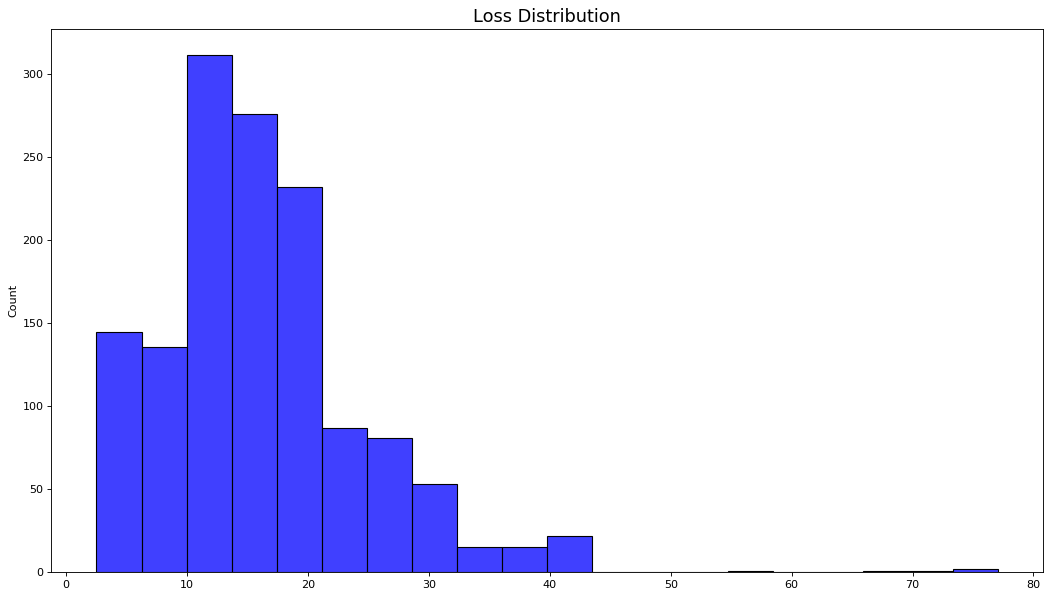

In [187]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

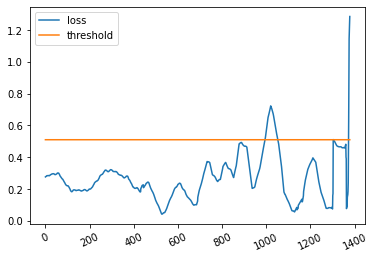

In [230]:
THRESHOLD =0.51

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss/60 for loss in losses]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();


In [231]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [232]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 68
True Negative	 1246
False Positive	 59
False Negative	 6
Accuracy	 0.9528643944887599
Precision	 0.5354330708661418
Recall	 0.918918918918919
f-measure	 0.6766169154228856
cohen_kappa_score	 0.653092502215703
auc	 0.936854095474785
roc_auc	 0.936854095474785
